<H2>Deep Learning - CNN-RNN - TimeDistributed

<H3>Parameters

In [1]:
#WESAD
start_participant = 2
final_participant = 17

number_of_classes = 2

path = 'WESAD'

if (number_of_classes == 2):
    # Amount of Data
    size_line = 240

    size_column_train = 100
    size_column_test = 32
    
    # Matrix Dimension
    width = 10          #n
    height = 24        #m
    channel = 35         #c

elif (number_of_classes == 4):
    # Amount of Data
    size_line = 360
    
    size_column_train = 100
    size_column_test = 35
    
    # Matrix Dimension
    width = 10          #n
    height = 36        #m
    channel = 35         #c

# Batch Size
batch_size = 50

# Image Format
image_size = (width, height, channel)

#Epochs
epochs = 1000

#Optimizer
optimizer = "rmsprop"

#Activation
activation = "softmax"

<H3>Libraries

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.models import load_model
from keras.layers import Dense, LSTM, Dropout, Conv1D, Conv2D, MaxPooling2D, Flatten, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc ,precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error
import pandas as pd
import scipy.io as sio
import os
from os import listdir
from os.path import isfile, join
import numpy.fft as fft
from scipy.signal import find_peaks,peak_widths
import keras
from keras import backend as K
import sys

<H3>Functions and Methods

<H4>Feature Extraction

In [3]:
def feature_extraction(df,classes):
    df_new = pd.DataFrame()
    
    for i in range(int(len(df)/700)):
        x = df.iloc[i:i+int(len(df)/700),:]
        mn_acc_x = x['ACC_X'].mean()
        mn_acc_y = x['ACC_Y'].mean()
        mn_acc_z = x['ACC_Z'].mean()
        std_acc_x = x['ACC_X'].std()
        std_acc_y = x['ACC_Y'].std()
        std_acc_z = x['ACC_Z'].std()
        itgl_acc_x = np.trapz(x['ACC_X'])
        itgl_acc_y = np.trapz(x['ACC_Y'])
        itgl_acc_z = np.trapz(x['ACC_Z'])
        mn_emg = x['EMG'].mean()
        std_emg = x['EMG'].std()
        max_emg = np.amax(x['ACC_X'])
        min_emg = np.amin(x['ACC_X']) 
        dr_emg = max_emg/min_emg
        #rint(dr_emg)
        itgl_emg = np.trapz(x['EMG'])
        med_emg = np.median(x['EMG'])
        per_10_emg = np.percentile(x['EMG'],10)
        per_90_emg = np.percentile(x['EMG'],90)
        peaks,properties = find_peaks(x['EMG'],height = 0)
        mn_pk_amp = np.mean(properties['peak_heights'])
        std_pk_amp = np.std(properties['peak_heights'])
        sum_pk_amp = np.sum(properties['peak_heights'])
        mn_temp = x['TEMP'].mean()
        std_temp = x['TEMP'].std()
        max_temp = x['TEMP'].max()
        min_temp = x['TEMP'].min()
        dr_temp = max_temp/min_temp
        mn_eda = x['EDA'].mean()
        std_eda = x['EDA'].std()
        max_eda = x['EDA'].max()
        min_eda = x['EDA'].min()
        dr_eda = max_eda/min_eda
        peaks,properties = find_peaks(x['EDA'],height = 0)
        mn_scr = np.mean(properties['peak_heights'])
        std_scr = np.std(properties['peak_heights'])   
        num_scr = np.size(peaks)
        sum_scr = np.sum(properties['peak_heights'])
        width_scr = peak_widths(x['EDA'], peaks, rel_height=0)
        ht_scr = properties['peak_heights']
        ar_scr = 0.5*np.matmul(ht_scr,width_scr[1])
        df_new = df_new.append({'class':classes,'mean_accx':mn_acc_x,'mean_accy':mn_acc_y,'mean_accz':mn_acc_z,
                                'std_accx':std_acc_x,'std_accy':std_acc_y,'std_accz':std_acc_z,
                                'integral_accx':itgl_acc_x,'integral_accy':itgl_acc_y,'integral_accz':itgl_acc_z,
                                'mean_emg':mn_emg,'std_emg':std_emg,'drange_emg':dr_emg,'integral_emg':itgl_emg,
                                'median_emg':med_emg,'percentile_10_emg':per_10_emg,'percentile_90_emg':per_90_emg,
                                'number_peaks':peaks.size,'mean_peak_amplitudes':mn_pk_amp,'std_peak_amplitude':std_pk_amp,
                                'sum_peak_amplitude':sum_pk_amp,'mean_temp':mn_temp,'std_temp':std_temp,'drange_temp':dr_temp,
                                'max_temp':max_temp,'min_temp':min_temp,'mean_eda':mn_eda,'std_eda':std_eda,
                                'max_eda':max_eda,'min_eda':min_eda,'drange_eda':dr_eda,'mean_scr_peaks':mn_scr,
                                'std_scr_peaks':std_scr,'total_scr_peaks':num_scr,'sum_scr_peaks':sum_scr,
                                'area_peaks_scr':ar_scr},ignore_index = True)
    return(df_new)

<H4>Data Collect

In [4]:
def data_collect(file_name):
    df = pd.read_pickle(os.path.abspath(file_name))
    df_labels = df['label']
    df_labels = np.reshape(df_labels,(len(df['label']),1))
    data = np.concatenate((df['signal']['chest']['ACC'],df['signal']['chest']['ECG'],df['signal']['chest']['EMG'],df['signal']['chest']['EDA'],df['signal']['chest']['Temp'],df['signal']['chest']['Resp'],df_labels),axis = 1)
    data = np.array([data[i] for i in range(len(data[:,8])) if 4 >= data[i,8] > 0 ])
    
    return data

<h4>Reshape the Matriz

In [5]:
def reshape_list (size_column_train, size_column_test, width, height, channel, X_train, X_val):
    X_train = np.reshape(X_train, (size_column_train, 1, width, height, channel))
    X_val = np.reshape(X_val, (size_column_test, 1, width, height, channel))
    
    return(X_train, X_val)

<H4>Create the Model - Sequential

In [6]:
def create_model():
    model = Sequential()
    
    return(model)

<H4>Adds First Layer - CNN

In [7]:
def CNN_first_layer(model, image_size):
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=image_size, padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    return(model)

<H4>Adds Second Layer - CNN

In [8]:
def CNN_second_layer(model):
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same' ))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    return(model)

<H4>Adds Third Layer - CNN

In [9]:
def CNN_third_layer(model):
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    return(model)

<H4>Adds Last Layer - CNN

In [10]:
#Dense part
def CNN_last_layer(model, activation):
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(number_of_classes, activation=activation))
    
    return(model)

<H4>Adds First Layer - RNN

In [11]:
# create and fit the LSTM network
def RNN_first_layer(model, first_model, image_size):
    model.add(TimeDistributed(first_model))
    model.add(LSTM(512, return_sequences=True, input_shape=image_size))
    
    return(model)

<H4>Adds Second Layer - RNN

In [12]:
def RNN_second_layer(model):
    model.add(LSTM(256, return_sequences=True))
    
    return(model)

<H4>Adds Third Layer - RNN

In [13]:
def RNN_third_layer(model):
    model.add(LSTM(128, return_sequences=True))
    
    return(model)

<H4>Adds Last Layer - RNN

In [14]:
def RNN_last_layer(model, number_of_classes, activation):
    model.add(LSTM(64, return_sequences=True))

    model.add(LSTM(32))
    model.add(Dense(number_of_classes, activation=activation))
    
    return(model)

<H4>Train Model

In [15]:
def train_the_model(model, X_train, Y_train, X_val, Y_val, batch_size, epochs, optimizer):
    print("---------------------------------------------")
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    checkpointer = ModelCheckpoint(filepath="Deep_Learning_Model/" + optimizer + "_{epoch:02d}.hdf5", monitor='val_loss', verbose=1, save_best_only=True)
    lr_reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.1, min_delta=0.0001, patience=5, verbose=1)
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), verbose=1, shuffle=False, callbacks=[checkpointer, lr_reduce])
    #model = load_model('BeWell_DL_model.h5')
    print("---------------------------------------------")
    #model.save('BeWell_DL_model.h5')
    
    predictions = model.predict(X_val)
    score = accuracy_score(change(Y_val), change(predictions))
    print("---------------------------------------------")
    print("Score: " + str(score))
    print("---------------------------------------------")
    model_evalutation(history, X_val, Y_val, model)
    print("---------------------------------------------")
    
    return(model)

<H3>Validation

<h4>Accuracy

In [16]:
def change(x): 
    answer = np.zeros((np.shape(x)[0]))
    for i in range(np.shape(x)[0]):
        max_value = max(x[i, :])
        max_index = list(x[i, :]).index(max_value)
        answer[i] = max_index
    return answer.astype(np.int)

<h4>Evaluation

In [17]:
def model_evalutation(history, X_val, Y_val, model):
    score = model.evaluate((X_val),Y_val)
    print("Model Accuracy: %.2f%%" % (score[1]*100))

    plt.figure(figsize=(15,5))

    # Plot training & validation accuracy values
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')

    plt.suptitle("Model Accuracy and Model Loss")
    plt.tight_layout()
    plt.show()

<H3>Calling Functions and Methods

In [18]:
dataset = np.array([])

for i in range(start_participant, final_participant):
    file_name = path + '/S'+str(i) + '/S'+str(i)+'.pkl'
    if (i == 2) :
        dataset = data_collect(file_name)
    elif (i == 12) :
    elif (i >= 3 & i <= 17) :
        dataset = np.concatenate((dataset,data_collect(file_name)),axis=0)
    #else :
        #if i != 12 :
            #dataset = np.concatenate((dataset,data_collect(file_name)),axis = 0)
            
df = pd.DataFrame({'ACC_X':dataset[:,0],'ACC_Y':dataset[:,1],'ACC_Z':dataset[:,2],'ECG':dataset[:,3],'EDA':dataset[:,4],'EMG':dataset[:,5],'RESP':dataset[:,6],'TEMP':dataset[:,7],'TARGET':dataset[:,8]})

---


In [19]:
baseline_df = pd.DataFrame(columns = ['ACC_X','ACC_Y','ACC_Z','ECG','EDA','EMG','RESP','TEMP','TARGET'])
baseline_df = df.loc[df['TARGET'] == 1.0].copy()
baseline_df = baseline_df.reset_index()
print("Size Baseline: " + str(len(baseline_df)))

if (number_of_classes >= 2):
    stress_df = pd.DataFrame(columns = ['ACC_X','ACC_Y','ACC_Z','ECG','EDA','EMG','RESP','TEMP','TARGET'])
    stress_df = df.loc[df['TARGET'] == 2.0].copy()
    stress_df = stress_df.reset_index()
    print("Size Stress: " + str(len(stress_df)))

if (number_of_classes >= 3):
    amusement_df = pd.DataFrame(columns = ['ACC_X','ACC_Y','ACC_Z','ECG','EDA','EMG','RESP','TEMP','TARGET'])
    amusement_df = df.loc[df['TARGET'] == 3.0].copy()
    amusement_df = amusement_df.reset_index()
    print("Size Amusement: " + str(len(amusement_df)))
    
if (number_of_classes >= 4):
    meditation_df = pd.DataFrame(columns = ['ACC_X','ACC_Y','ACC_Z','ECG','EDA','EMG','RESP','TEMP','TARGET'])
    meditation_df = df.loc[df['TARGET'] == 4.0].copy()
    meditation_df = meditation_df.reset_index()
    print("Size Meditation: " + str(len(meditation_df)))

Size Baseline: 11501002
Size Stress: 6470101


In [20]:
baseline_df = feature_extraction(baseline_df, 1)
print("Size Baseline: " + str(len(baseline_df)))
baseline_df = baseline_df[:16000]

if (number_of_classes >= 2):
    stress_df = feature_extraction(stress_df, 2)
    print("Size Stress: " + str(len(stress_df)))
    stress_df = stress_df[:8000]

if (number_of_classes >= 3):
    amusement_df = feature_extraction(amusement_df, 3)
    print("Size Amusement: " + str(len(amusement_df)))
    amusement_df = amusement_df[:4000]

if (number_of_classes >= 4):
    meditation_df = feature_extraction(meditation_df, 4)
    print("Size Meditation: " + str(len(meditation_df)))
    meditation_df = meditation_df[:8000]

<ipython-input-3-03a11780cc0f>:55: PeakPropertyWarning: some peaks have a width of 0
  width_scr = peak_widths(x['EDA'], peaks, rel_height=0)


Size Baseline: 16430
Size Stress: 9243


In [28]:
dataset_x = pd.DataFrame()
dataset_x_val = pd.DataFrame()
dataset_y_temp = pd.DataFrame(columns = ['class'])
dataset_y = pd.DataFrame(columns = ['class'])
dataset_y_val = pd.DataFrame(columns = ['class'])


dataset_x = dataset_x.append(baseline_df)
dataset_y = baseline_df['class']

if (number_of_classes >= 2):
    dataset_x = dataset_x.append(stress_df)
    dataset_y_temp = stress_df['class']
    dataset_y = dataset_y.append(dataset_y_temp)
    

if (number_of_classes >= 3):
    dataset_x = dataset_x.append(amusement_df)
    dataset_y_temp = amusement_df['class']
    dataset_y = dataset_y.append(dataset_y_temp)
    
if (number_of_classes >= 4):
    dataset_x = dataset_x.append(meditation_df)
    dataset_y_temp = meditation_df['class']
    dataset_y = dataset_y.append(dataset_y_temp)
    
dataset_x = dataset_x.reset_index()
dataset_y = dataset_y.reset_index()
dataset_x = dataset_x.drop(['index','class'], axis='columns')
dataset_y = dataset_y.drop(['index'], axis='columns')
dataset_x_val = dataset_x[10000:15120]
dataset_y_val = dataset_y[10000:15120]
dataset_x_val = dataset_x_val.append(dataset_x[20000:22560])
dataset_y_val = dataset_y_val.append(dataset_y[20000:22560])
dataset_x_val = dataset_x_val.append(dataset_x[25000:27510])
dataset_y_val = dataset_y_val.append(dataset_y[25000:27510])
dataset_x_val = dataset_x_val.append(dataset_x[30000:32510])
dataset_y_val = dataset_y_val.append(dataset_y[30000:32510])
dataset_x_val = dataset_x_val.reset_index()
dataset_y_val = dataset_y_val.reset_index()
dataset_x_val = dataset_x_val.drop(['index'], axis='columns')
dataset_y_val = dataset_y_val.drop(['index'], axis='columns')

print("Size Dataset: " + str(dataset_x.shape))
print("Size Dataset: " + str(dataset_y.shape))
print("Size Dataset: " + str(dataset_x_val.shape))
print("Size Dataset: " + str(dataset_y_val.shape))

Size Dataset: (24000, 35)
Size Dataset: (24000, 1)
Size Dataset: (7680, 35)
Size Dataset: (7680, 1)


In [29]:
x_train = dataset_x.to_numpy()
y_train = dataset_y.to_numpy()
x_val = dataset_x_val.to_numpy()
y_val = dataset_y_val.to_numpy()

Y_train = np.zeros((size_column_train, number_of_classes))
for i in range(len(Y_train)):
    if y_train[i*size_line] == 1:
        Y_train[i,0] = 1
    elif y_train[i*size_line] == 2:
        Y_train[i,1] = 1
    elif y_train[i*size_line] == 3:
        Y_train[i,2] = 1
    else:
        Y_train[i,3] = 1
        
Y_val = np.zeros((size_column_test, number_of_classes))
for i in range(len(Y_val)):
    if y_train[i*size_line] == 1:
        Y_val[i,0] = 1
    elif y_train[i*size_line] == 2:
        Y_val[i,1] = 1
    elif y_train[i*size_line] == 3:
        Y_val[i,2] = 1
    else:
        Y_val[i,3] = 1

In [30]:
X_train, X_val = reshape_list(size_column_train, size_column_test, width, height, channel, x_train, x_val)

In [31]:
CNN_model = create_model()

In [32]:
CNN_model = CNN_first_layer(CNN_model, image_size)

In [33]:
CNN_model = CNN_second_layer(CNN_model)

In [34]:
CNN_model = CNN_third_layer(CNN_model)

In [35]:
CNN_model = CNN_last_layer(CNN_model, activation)

In [36]:
model = create_model()

In [37]:
model = RNN_first_layer(model, CNN_model, image_size)

In [38]:
model = RNN_second_layer(model)

In [39]:
model = RNN_third_layer(model)

In [40]:
model = RNN_last_layer(model, number_of_classes, activation)

---------------------------------------------
Epoch 1/1000
2/2 [==============================] - ETA: 0s - loss: 0.6945 - accuracy: 0.4700
Epoch 00001: val_loss improved from inf to 0.68808, saving model to Deep_Learning_Model/rmsprop_01.hdf5
2/2 [==============================] - 2s 998ms/step - loss: 0.6945 - accuracy: 0.4700 - val_loss: 0.6881 - val_accuracy: 1.0000
Epoch 2/1000
2/2 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.6700
Epoch 00002: val_loss improved from 0.68808 to 0.68439, saving model to Deep_Learning_Model/rmsprop_02.hdf5
2/2 [==============================] - 0s 112ms/step - loss: 0.6924 - accuracy: 0.6700 - val_loss: 0.6844 - val_accuracy: 1.0000
Epoch 3/1000
2/2 [==============================] - ETA: 0s - loss: 0.6911 - accuracy: 0.6700
Epoch 00003: val_loss improved from 0.68439 to 0.68120, saving model to Deep_Learning_Model/rmsprop_03.hdf5
2/2 [==============================] - 0s 111ms/step - loss: 0.6911 - accuracy: 0.6700 - val_l

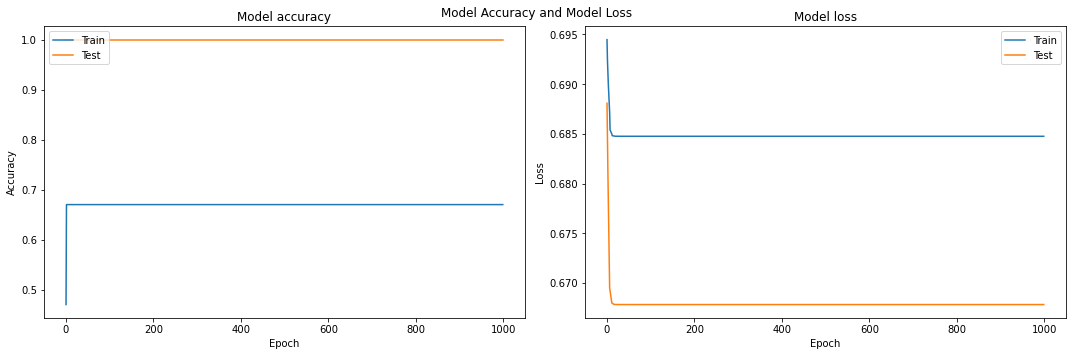

---------------------------------------------


In [41]:
#model = train_the_model(model, X_train, Y_train, X_val, Y_val, batch_size, epochs, optimizer)